In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from math import sqrt
from IPython.display import Latex,display,Math
print("Modules Imported!")

Modules Imported!


# Steady-state distributions of Markov chains
(30 pts)

In this excercise, let 
$$P=\left[\begin{array}{cc}
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{3} & \frac{2}{3}
\end{array}\right]$$
denote the transition matrix of a Markov chain process $X_n$ with two states $\{W,S\}$. For example, $Pr(X_n=W|X_{n-1}=S)=\frac13$. Recall that if $\pi^{(n)}$ denotes the distribution of $X_n$, we have $\pi^{(n+1)}=\pi^{(n)}P$. Note that $X_n$ is irreducible and aperiodic. So it has a unique steady state distribution $\phi$, which corresponds to the left eigenvector for eigenvalue 1.

_____________
Using python find the eigenvalues and eigenvectors of $P$. To do this, use [`numpy.linalg`](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html): 
``` python
import numpy.linalg as la
```
and then use [`numpy.linalg.eig`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig):
``` python
w,v = la.eig(P.T)
```
to get the eigenvaules/vectors. Find the eigenvector that corresponds to the eigenvalue 1. To do so, make sure you understand the output format of `eig`. Normalize this eigenvector such that it sums to 1 and verify that we indeed have $\phi=P\phi$ (use `np.dot(P,phi)`).

In [ ]:
import numpy.linalg as la
P=np.array([[1/2,1/2],[1/3,2/3]])
# ...

____________
Pick an arbitrary initial distribution $\pi^{(0)}$. Find $\pi^{(n)}$ for $n=0,1,2,3,4$. Does convergence to $\phi$ in fact occur? From the Perron-Frobenius theorem, we also know that the rows of $P^n$ converge to $\phi$. Verify this through computation.

In [ ]:
# ...

__Sampling from Markov Chains:__ Suppose that we need to generate iid (independent and identically distributed) random samples from a given distribution $q$. Sometimes, it is difficult to do this directly, but we can construct a Markov chain whose stationary distribution is $q$. Then we can simulate this Markov chain and sample from it. Technically speaking, these samples are identically distributed but not independent. However, if there is enough of a gap between consecutive samples, they are "approximately" independent. For example, in the above Markov chain, if we take a sample at $n=3,6,9,\dotsc$, we get nearly independent samples since $\pi P^3\simeq \phi$ for any $\pi$. (In practice we may decide to use all samples since dropping samples has a computational cost.)

Simulate the above Markov chain by starting from an arbitrary state and take 1000 samples at steps that are multiples of 3. Verify that the distribution of these samples is the same as $\phi$.

_Hint_: Randomly transitioning to the next state where the trasition probabilities for going out of the current state are given by $p$ is equivalent to generating a random variable that is equal to $i$ with probability $p_i$, which can be done as follows (why?):
```python
r = st.uniform.rvs()
rv = np.sum(r>np.cumsum(p))
```

In [ ]:
def sample_MC(P,N,skip):
    M = len(P)
    y = [0] * N # initializing the vector of samples
    state = 0 # starting the chain from state 0
    # ...
    return(y)

In [ ]:
y = sample_MC(P,1000,3)
# ...

<hr />
# Gibbs, Metropolis, Hamiltonian Metropolis Sampling
(70 pts)

We will implement several MCMC sampling algorithms and compare and contrast their performance. To make things simple, the code for everything except the sampling algorithms are given. You should review and understand all the given code and make sure the code you write is compatible. If you use a different language, you need to re-write the given code.

<hr />
__Setting up target distributions:__ First, we will define three python functions representing our target distributions, which are
- $p_0$: a 2-d multivarate normal (__MVN__) with independent components,
- $p_1$: a 2-d MVN with highly dependant components, and
- $p_2$: a 2-d mixture of two MVNs.

We have chosen 2-d targets to make it easier to plot the results.

In [2]:
m = np.empty([4,2]); c = np.empty([4,2,2])

m[0] = [0,0]; c[0] = [[1,0],[0,1]]

m[1] = [0,0]; c[1] = 2*np.array([[1,0.98],[.98,1]])


m[2] = [-1,-1]; c[2] = [[.7,.3],[.3,.7]]
m[3] = [ 1, 1]; c[3] = [[.7,.3],[.3,.7]]

def p0(th):
    rv = st.multivariate_normal(mean=m[0],cov=c[0])
    grad = np.dot(th,np.linalg.inv(c[0])) # Note how the gradient is computed
    return [rv.pdf(th),grad]

def p1(th):
    rv = st.multivariate_normal(mean=m[1],cov=c[1])
    grad = np.dot(th,np.linalg.inv(c[1]))
    return [rv.pdf(th),grad]

def p2(th):
    rv1 = st.multivariate_normal(mean=m[2],cov=c[2])
    rv2 = st.multivariate_normal(mean=m[3],cov=c[3])
    return [rv1.pdf(th)+rv2.pdf(th), np.nan]

pp = [p0,p1,p2]

<hr/>
We will plot the mixture target distribution using contourf:

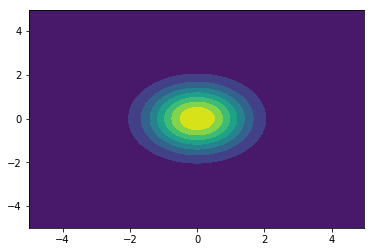

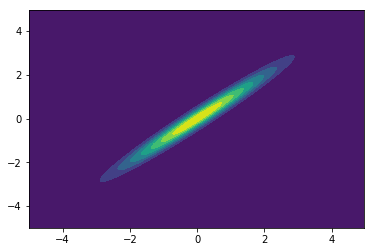

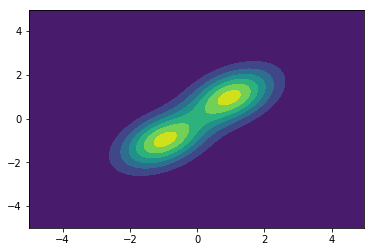

In [3]:
x,y = np.mgrid[-5:5:.05,-5:5:.05]
pos = np.empty(x.shape + (2,)) # the comma ensure (2,) is interpreted as tuple, (2) would be int
pos[:,:,0] = x; pos[:,:,1] = y
for p in pp:
    plt.figure()
    plt.contourf(x,y,p(pos)[0])

<hr>
__Sampling methods:__ Implement a Gibbs sampler, a metropolis sampler, and a Hamiltonian metropolis sampler.

For the metropolis algorithm, use a Normal jump distribution. The covariance of the jump distribution is passed to the functions as an argument. The metropolis algorithm should work for all three targets.

Implement the Gibbs and the HMC samplers for 2-d MVNs. So it only needs to work with $p_0$ and $p_1$ but not the mixture $p_2$. Note that the functions for $p_0$ and $p_1$ given above also pass the gradient in addition to the value of the pdf.

In [ ]:
# metropolis with normal jumps
def metropolis(target_p, covJump, init, N_samples):
    # covJump: the covariance of the mustivariate normal jumping distn
    # target_p is the target distribution from which we want to sample. this is a function
    # N_samples is the number of samples we want
    # th = np.empty((N,len(init))) ## th will hold the samples that we generate
    # th[0] = init ## the starting point, i.e., the first sample
    # ...
    
    # for i in range(1,N):
      # ...
    
    return # return th

In [ ]:
# Gibbs for 2-d normal
def Gibbs_normal(mean, cov, init, N_samples):
    # mean: mean of the target MVN distribution
    # cov: covariance of the target MVN
    # th = np.empty([N,2])
    # th[0] = init
    # ...
    return # return th

In [ ]:
# HMC with standard normal momentum proposal, refer to McKay, "Information Theory, Inference, and Learning Algorithms"
def HMC(target_p, eps, L, init, N_samples,):
    # eps is the scale of each leapfrog step
    # L is the number of leapfrog steps in each iteration
    # target_p(theta) returns [pdf, gradient] for the point theta
    # momentum_rv = ... ## proposal rv for momentum is a standard 2-d MVN
    # th = np.empty((N,len(init)))
    # ...
    return #return th


__Comparison of sampling methods:__ We now plot the samples obtained using each method for four random starting point. You need to run this 3 times to see the result for each of the targets. Note that Metropolis is the only method implemented here to handle $p_2$. Try different numbers of samples and a variety of values for the other parameters and compare the results of the methods. Describe the differences between the sampling methods based on this observations in a couple of paragraphs.

In [ ]:
# target distn

i = 2
p = pp[i]
N = 500

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = .1

# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        plt.axes(ax[j][k])
        plt.axis([-3,3,-3,3])
        plt.contourf(x,y,p(pos)[0])
        plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
        # with small number of samples try also ':k.' to see the order of samples

if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
            
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=.5) 

__corner:__ The [corner package](http://corner.readthedocs.io/en/latest/) is useful for demonstrating multivariate samples. Install it (open the Anaconda Prompt and type "pip install corner") and then run the following code. This should show the difference between Metropolis and HMC more clearly. In particular, describe the difference between the marginals.

In [ ]:
import corner
th = metropolis(pp[1], scale*covJump, init, 500)
corner.corner(th);

th = HMC(pp[1], 0.1, 10, init, 500)
corner.corner(th);